In [6]:
import time
import csv
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt

def extract_data(input_filepath):
    file = open(input_filepath, 'r', encoding='utf-8-sig')
    csvreader = csv.reader(file)
    stamp_list = []
    
    path = os.path.dirname(input_filepath)
    filename_ext = os.path.basename(input_filepath)
    filename = os.path.splitext(filename_ext)[0]

    if (filename == "MPDataExport"):
        # This skips the first row of the CSV file.
        next(csvreader)
        for i in csvreader:
            stamp_list.append(i)

        mx_stamps = []
        sys_stamps = []
        hr = []

        print(stamp_list[0])

        for j in range(len(stamp_list)):
            # print(stamp_list[j])
            time_obj_mx = datetime.strptime(stamp_list[j][0], '%d-%m-%Y %H:%M:%S.%f')
            # stamp_mx = 60*time_obj_mx.minute + time_obj_mx.second + time_obj_mx.microsecond / 1e6
            stamp_mx = time_obj_mx.timestamp()
            mx_stamps.append(stamp_mx)

            time_obj_sys = datetime.strptime(stamp_list[j][2], '%d-%m-%Y %H:%M:%S.%f')
            # stamp_sys = 60*time_obj_sys.minute + time_obj_sys.second + time_obj_sys.microsecond / 1e6
            stamp_sys = time_obj_sys.timestamp()
            sys_stamps.append(stamp_sys)

            hr.append(int(stamp_list[j][13]))

            # print(stamp_mx, stamp_sys)

        return mx_stamps, sys_stamps, hr

    else: # i.e. NOM_PLETH
        for i in csvreader:
            stamp_list.append(i)

        mx_stamps = []
        sys_stamps = []
        pleth = []

        print(stamp_list[0])

        for j in range(len(stamp_list)):
            # print(stamp_list[j])
            time_obj_mx = datetime.strptime(stamp_list[j][0], '%d-%m-%Y %H:%M:%S.%f')
            # stamp_mx = 60*time_obj_mx.minute + time_obj_mx.second + time_obj_mx.microsecond / 1e6
            stamp_mx = time_obj_mx.timestamp()
            mx_stamps.append(stamp_mx)

            time_obj_sys = datetime.strptime(stamp_list[j][2], '%d-%m-%Y %H:%M:%S.%f')
            # stamp_sys = 60*time_obj_sys.minute + time_obj_sys.second + time_obj_sys.microsecond / 1e6
            stamp_sys = time_obj_sys.timestamp()
            sys_stamps.append(stamp_sys)
            pleth.append(int(stamp_list[j][3]))

            # print(stamp_mx, stamp_sys)

        return mx_stamps, sys_stamps, pleth


def find_deltas(sys_stamps, mx_stamps):
    const_num = sys_stamps[0]
    deltas = []
    for i, stamp in enumerate(sys_stamps):
        if(stamp != const_num):
            const_num = stamp
            delta = sys_stamps[i-1] - mx_stamps[i-1]
            if(sys_stamps[i] - sys_stamps[i-1] > 0.3): # comparison for blips
                deltas.append(delta)
    return np.array(deltas)

def unroll_stamps(mx_stamps, batch_size = int(32), time_diff = 0.256):

    unrolled_stamps = []

    for i in range(int(len(mx_stamps)/batch_size)):
        current_stamp = mx_stamps[i * batch_size]
        # print(current_stamp)
        for j in range(batch_size):
            unrolled_val = current_stamp - time_diff + time_diff*(j+1)/batch_size
            # print(unrolled_val)
            unrolled_stamps.append(unrolled_val)
    
    return np.array(unrolled_stamps)

def apply_delta(mx_stamps, sys_mx_time_delta):
    return mx_stamps + sys_mx_time_delta


In [7]:
# filename = r"C:\Users\111\Documents\mmhealth_features\mmhealth_master\sensors\mx800\data_run4\NOM_PLETHWaveExport.csv"
filename = r"E:\mmhealth_data\91_1\NOM_PLETHWaveExport.csv"
filename_hr = r"E:\mmhealth_data\91_1\MPDataExport.csv"
mx_stamps, sys_stamps, pleth = extract_data(input_filepath=filename)
mx_stamps_hr, sys_stamps_hr, hr = extract_data(input_filepath=filename_hr)
sys_stamps = np.array(sys_stamps)
diff_sys = sys_stamps[1:] - sys_stamps[0:-1]

print(hr)

['14-01-2021 12:47:29.112', '38854656', '29-09-2021 10:33:52.476', '2416', '']
['14-01-2021 12:47:39.288', '38936064', '29-09-2021 10:34:01.710', '-', '-', '-', '-', '-', '-', '-', '-', '-', '99.2', '76', '3.198', '-', '-', '-']
[76, 76, 77, 77]


In [12]:
delta_array = find_deltas(sys_stamps, mx_stamps)
sys_mx_time_delta = np.mean(delta_array)

print(sys_mx_time_delta)

mx_unrolled = unroll_stamps(mx_stamps)
# print(mx_unrolled)
# print(mx_stamps)

22279590.66589062


[1.63293684e+09 1.63293684e+09 1.63293684e+09 ... 1.63293685e+09
 1.63293685e+09 1.63293685e+09]


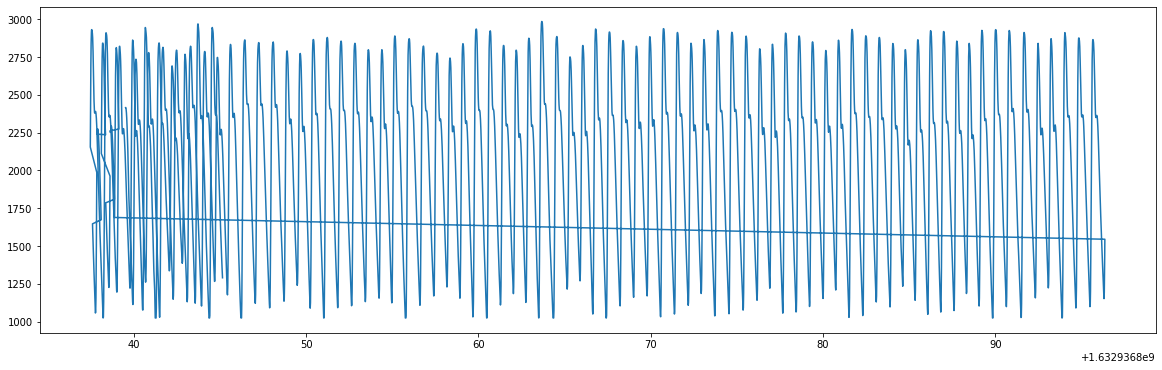

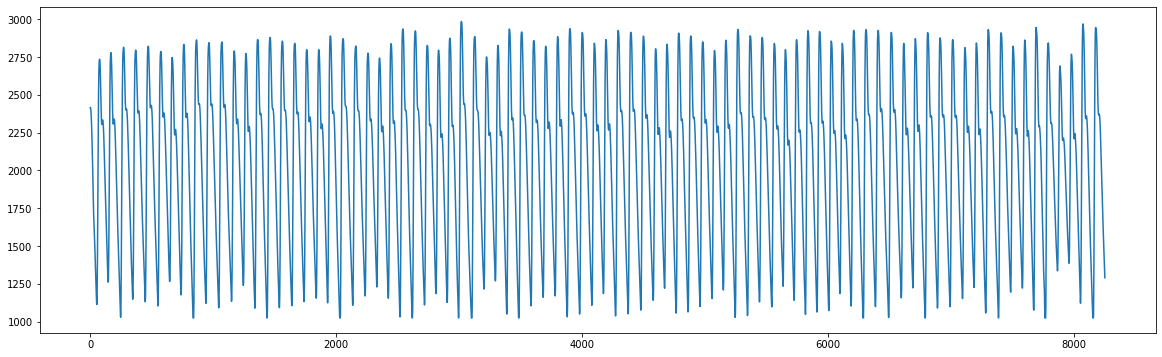

In [13]:
mx_local_system_stamps = apply_delta(mx_unrolled, sys_mx_time_delta)
print(mx_local_system_stamps)
plt.figure(figsize=(20,6))
plt.plot(mx_local_system_stamps, pleth)
plt.figure(figsize=(20,6))
plt.plot(pleth)